## greedy_heuristic_cvrp

In [1]:
%pip install vrplib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
Total Distance: 991.6705767881119
Route 0: [0, 30, 26, 16, 12, 1, 7, 0]
Route 1: [0, 24, 14, 27, 20, 5, 29, 15, 10, 0]
Route 2: [0, 13, 21, 31, 19, 17, 0]
Route 3: [0, 6, 3, 2, 23, 28, 8, 18, 22, 9, 0]
Route 4: [0, 25, 11, 4, 0]


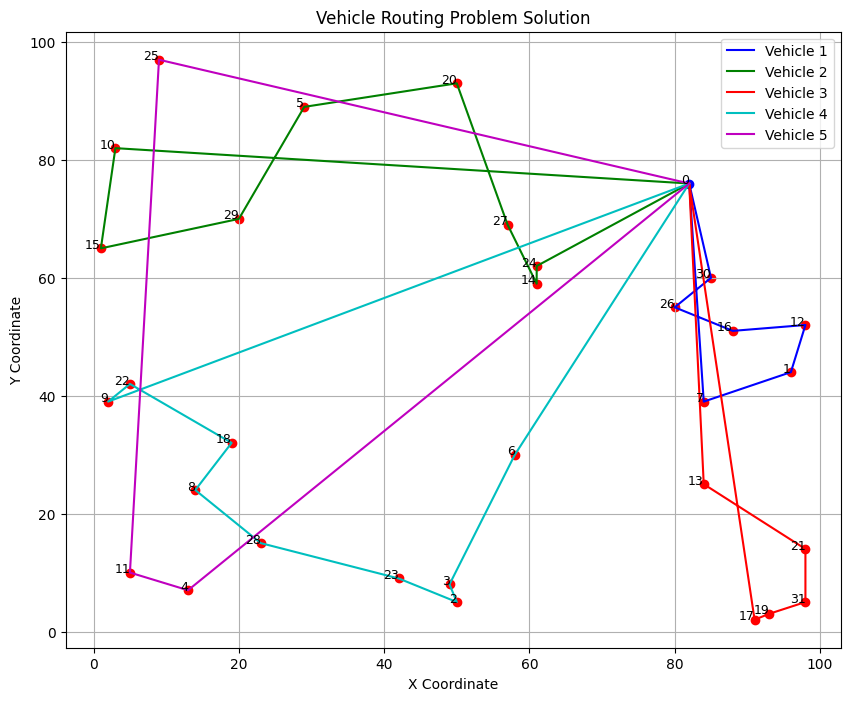

[[0, 30, 26, 16, 12, 1, 7, 0],
 [0, 24, 14, 27, 20, 5, 29, 15, 10, 0],
 [0, 13, 21, 31, 19, 17, 0],
 [0, 6, 3, 2, 23, 28, 8, 18, 22, 9, 0],
 [0, 25, 11, 4, 0]]

In [9]:
import os
import re
import vrplib
import random
import matplotlib.pyplot as plt
def plot_CVRP_solution(routes, node_coords):
    plt.figure(figsize=(10, 8))

    # Plot nodes
    for i, (x, y) in enumerate(node_coords):
        plt.scatter(x, y, c='blue' if i == 0 else 'red')
        plt.text(x, y, f'{i}', fontsize=9, ha='right')
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[node] for node in route]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c=colors[vehicle % len(colors)], label=f'Vehicle {vehicle + 1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routing Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def read_cvrp_data(file_name, ending='.vrp'):
    if file_name.endswith(ending):
        instance = vrplib.read_instance( file_name)
        if instance:
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    return data

def create_data_model(instance):
    data = {}
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix'] = instance['edge_weight']
    return data

def greedy_heuristic_cvrp(data):
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    demands = data['demand']
    capacity = data['vehicle_capacity']
    distance_matrix = data['distance_matrix']
    
    unvisited = set(range(len(distance_matrix))) - {depot}
    routes = [[] for _ in range(num_vehicles)]
    vehicle_loads = [0] * num_vehicles
    vehicle_active = [True] * num_vehicles  # 记录哪些车辆仍然可用

    for vehicle_id in range(num_vehicles):
        if not unvisited:
            break  # 所有点已访问

        routes[vehicle_id].append(depot)
        current_node = depot

        while unvisited:
            next_node = min(unvisited, key=lambda node: distance_matrix[current_node][node])
            if vehicle_loads[vehicle_id] + demands[next_node] > capacity:
                break  # 负载超限，换下一个车辆

            routes[vehicle_id].append(next_node)
            vehicle_loads[vehicle_id] += demands[next_node]
            unvisited.remove(next_node)
            current_node = next_node
        
        routes[vehicle_id].append(depot)

    # 确保所有点都被访问
    if unvisited:
        print("Warning: Some points were not visited. Reassigning them...")
        for node in unvisited:
            min_vehicle = min(range(num_vehicles), key=lambda v: vehicle_loads[v])
            routes[min_vehicle].insert(-1, node)
            vehicle_loads[min_vehicle] += demands[node]

    total_distance = sum(
        sum(distance_matrix[routes[i][j]][routes[i][j+1]] for j in range(len(routes[i])-1))
        for i in range(num_vehicles)
    )
    
    print(f"Total Distance: {total_distance}")
    for i, route in enumerate(routes):
        print(f"Route {i}: {route}")
    plot_CVRP_solution(routes, data['locations'])
    return routes


# 运行示例
instance = read_cvrp_data('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp')

greedy_heuristic_cvrp(instance)





## ant_colony_optimization

Best Distance: 975.1623203711274
Route 0: [0, 20, 5, 25, 10, 15, 9, 22, 8, 18, 29, 26, 0]
Route 1: [0, 28, 11, 4, 23, 3, 2, 6, 14, 0]
Route 2: [0, 30, 16, 12, 1, 7, 31, 0]
Route 3: [0, 27, 24, 17, 19, 21, 0]
Route 4: [0, 13, 0]


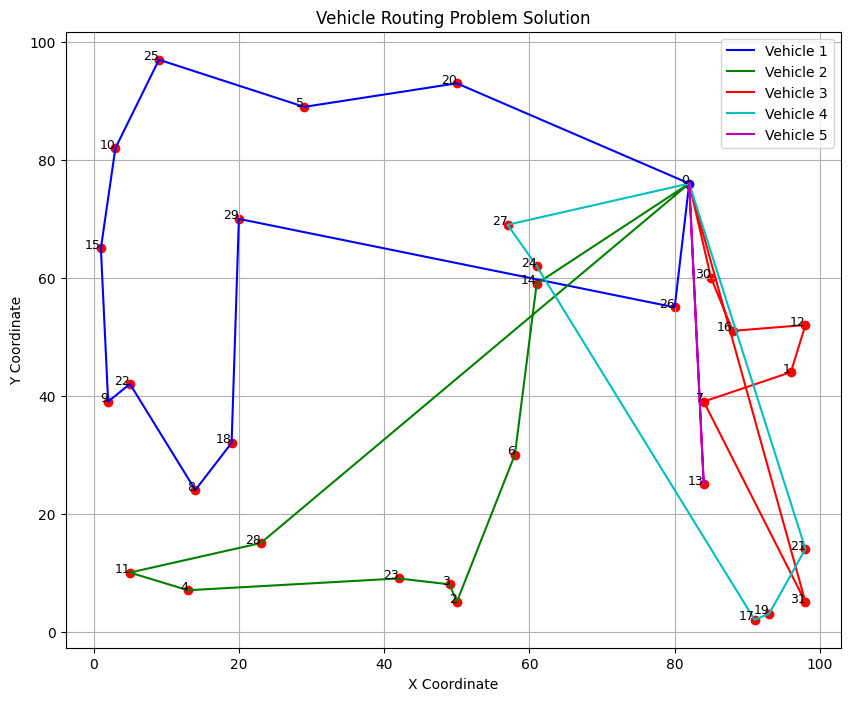

In [11]:

import numpy as np


def ant_colony_optimization(data, num_ants=10, num_iterations=100, alpha=1, beta=2, rho=0.5, Q=100):
    num_locations = data['num_locations']
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    distance_matrix = np.array(data['distance_matrix'])
    demands = data['demand']
    capacity = data['vehicle_capacity']
    
    pheromone = np.ones((num_locations, num_locations))
    best_routes = None
    best_distance = float('inf')
    
    for _ in range(num_iterations):
        all_routes = []
        all_distances = []
        
        for _ in range(num_ants):
            routes = [[] for _ in range(num_vehicles)]
            vehicle_loads = [0] * num_vehicles
            unvisited = set(range(num_locations)) - {depot}
            
            for vehicle_id in range(num_vehicles):
                routes[vehicle_id].append(depot)
                current_node = depot
                
                while unvisited:
                    probabilities = []
                    nodes = []
                    
                    for node in unvisited:
                        if vehicle_loads[vehicle_id] + demands[node] <= capacity:
                            tau = pheromone[current_node][node] ** alpha
                            eta = (1 / (distance_matrix[current_node][node] + 1e-6)) ** beta
                            probabilities.append(tau * eta)
                            nodes.append(node)
                    
                    if not nodes:
                        break
                    
                    probabilities = np.array(probabilities) / sum(probabilities)
                    next_node = np.random.choice(nodes, p=probabilities)
                    routes[vehicle_id].append(next_node)
                    vehicle_loads[vehicle_id] += demands[next_node]
                    unvisited.remove(next_node)
                    current_node = next_node
                
                routes[vehicle_id].append(depot)
            
            total_distance = sum(
                sum(distance_matrix[routes[i][j]][routes[i][j+1]] for j in range(len(routes[i])-1))
                for i in range(num_vehicles)
            )
            
            all_routes.append(routes)
            all_distances.append(total_distance)
            
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = routes
        
        pheromone *= (1 - rho)
        for routes, total_distance in zip(all_routes, all_distances):
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone[route[i]][route[i + 1]] += Q / total_distance
    
    print(f"Best Distance: {best_distance}")
    for i, route in enumerate(best_routes):
        print(f"Route {i}: {route}")
    return best_routes

# 运行示例

routes = ant_colony_optimization(instance)
plot_CVRP_solution(routes, instance['locations'])

## OR-tools

Successfully read A-n44-k6.vrp
Successfully read A-n44-k6.vrp
{'name': 'A-n44-k6', 'comment': '(Augerat et al, No of trucks: 6, Optimal value: 937)', 'type': 'CVRP', 'dimension': 44, 'edge_weight_type': 'EUC_2D', 'capacity': 100, 'node_coord': array([[14, 68],
       [73,  2],
       [13, 47],
       [37, 44],
       [34, 63],
       [58, 98],
       [33, 42],
       [18, 98],
       [24, 79],
       [17, 28],
       [72, 67],
       [78, 63],
       [42, 48],
       [ 1,  2],
       [ 2, 28],
       [32, 82],
       [97, 38],
       [39, 53],
       [87,  1],
       [42, 77],
       [83, 27],
       [79, 92],
       [22, 39],
       [58, 32],
       [53, 84],
       [38, 37],
       [63, 59],
       [42, 88],
       [32, 88],
       [38, 23],
       [63, 32],
       [22, 73],
       [88, 94],
       [58, 78],
       [43, 62],
       [73,  1],
       [17, 32],
       [87, 79],
       [12, 24],
       [48, 53],
       [48, 23],
       [ 7, 37],
       [98, 77],
       [34, 12]]), 'deman

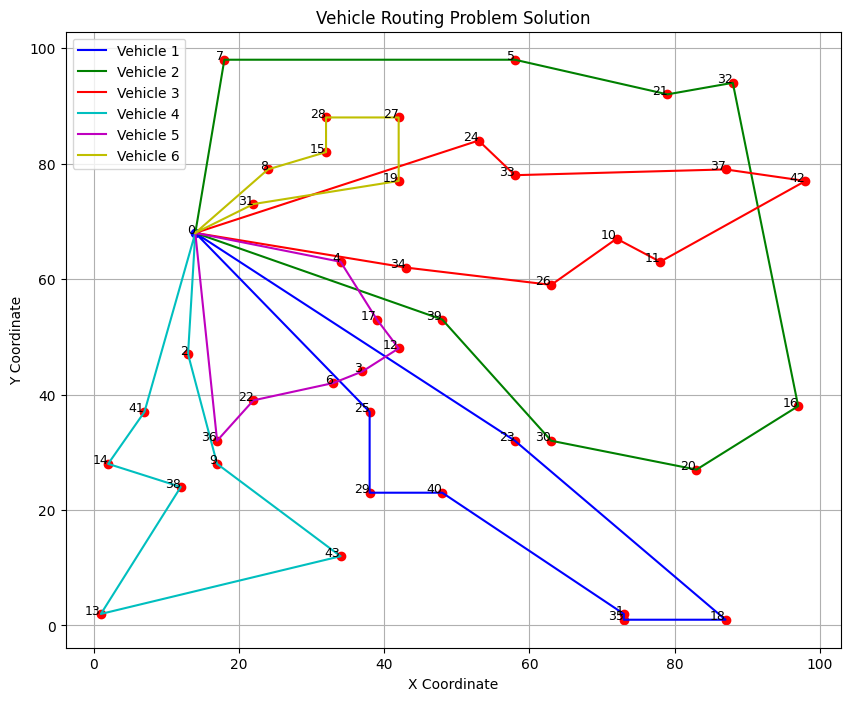

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def solve_cvrp_with_ortools(data):
    manager = pywrapcp.RoutingIndexManager(
         data["num_locations"], data['num_vehicles'], 0)
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index, 0, [data['vehicle_capacity']] * data['num_vehicles'], True, 'Capacity')
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    solution = routing.SolveWithParameters(search_parameters)
    print_solution(data, manager, routing, solution)
    if solution:
        return extract_solution(data, manager, routing, solution)
    else:
        print("No solution found.")
        return []

def extract_solution(data, manager, routing, solution):
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

instances = read_all_instances('./cvrp','.vrp')
def create_data_model(instance):
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = instance['depot']
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demands'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    
    return data

def print_solution(data, manager, routing, solution):
    if solution:
        total_distance = 0
        routes = []
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route = []
            route_distance = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            total_distance += route_distance
            print(total_distance)
            routes.append(route)
        print(f'Total distance of all routes: {total_distance}m')
        return routes
    else:
        print('No solution found.')
        return []

instances = read_all_instances('./cvrp', '.vrp')
print(instances[0])
if instances:
    data_model = create_data_model(instances[0])
    routes = solve_cvrp_with_ortools(data_model)
    plot_CVRP_solution(routes, data_model['locations'])

Best Distance: 978.037315784732
Route 0: [0, 27, 20, 5, 25, 10, 29, 22, 9, 8, 18, 26, 0]
Route 1: [0, 30, 16, 12, 1, 7, 31, 14, 0]
Route 2: [0, 13, 21, 19, 17, 2, 3, 0]
Route 3: [0, 6, 23, 28, 4, 11, 15, 0]
Route 4: [0, 24, 0]


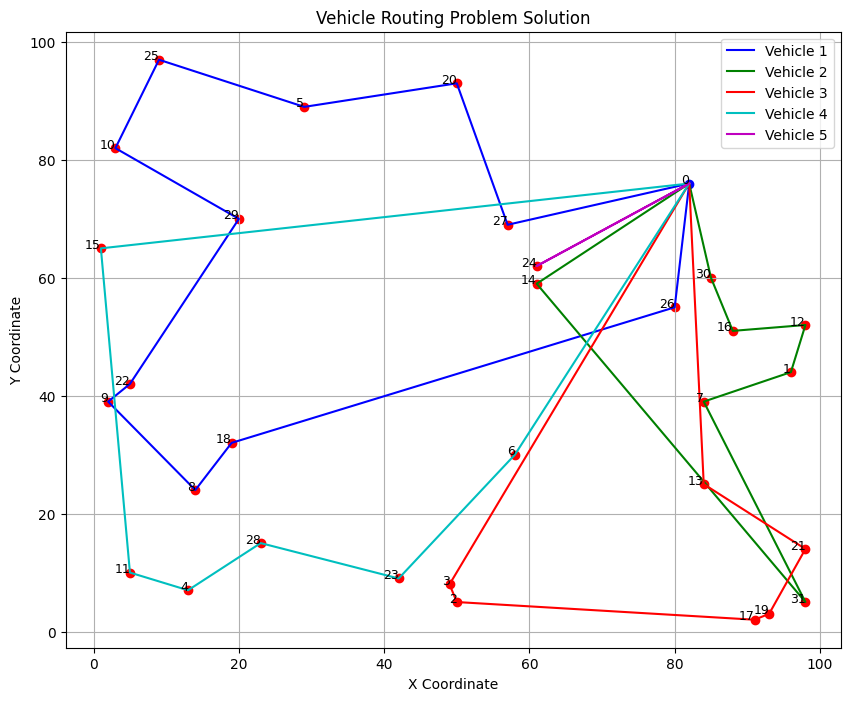

In [19]:

import numpy as np


def ant_colony_optimization(data, num_ants=10, num_iterations=100, alpha=1, beta=2, rho=0.5, Q=100):
    num_locations = data['num_locations']
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    distance_matrix = np.array(data['distance_matrix'])
    demands = data['demand']
    capacity = data['vehicle_capacity']
    
    pheromone = np.ones((num_locations, num_locations))
    best_routes = None
    best_distance = float('inf')
    
    for _ in range(num_iterations):
        all_routes = []
        all_distances = []
        
        for _ in range(num_ants):
            routes = [[] for _ in range(num_vehicles)]
            vehicle_loads = [0] * num_vehicles
            unvisited = set(range(num_locations)) - {depot}
            
            for vehicle_id in range(num_vehicles):
                routes[vehicle_id].append(depot)
                current_node = depot
                
                while unvisited:
                    probabilities = []
                    nodes = []
                    
                    for node in unvisited:
                        if vehicle_loads[vehicle_id] + demands[node] <= capacity:
                            tau = pheromone[current_node][node] ** alpha
                            eta = (1 / (distance_matrix[current_node][node] + 1e-6)) ** beta
                            probabilities.append(tau * eta)
                            nodes.append(node)
                    
                    if not nodes:
                        break
                    
                    probabilities = np.array(probabilities) / sum(probabilities)
                    next_node = np.random.choice(nodes, p=probabilities)
                    routes[vehicle_id].append(next_node)
                    vehicle_loads[vehicle_id] += demands[next_node]
                    unvisited.remove(next_node)
                    current_node = next_node
                
                routes[vehicle_id].append(depot)
            
            total_distance = sum(
                sum(distance_matrix[routes[i][j]][routes[i][j+1]] for j in range(len(routes[i])-1))
                for i in range(num_vehicles)
            )
            
            all_routes.append(routes)
            all_distances.append(total_distance)
            
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = routes
        
        pheromone *= (1 - rho)
        for routes, total_distance in zip(all_routes, all_distances):
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone[route[i]][route[i + 1]] += Q / total_distance
    
    print(f"Best Distance: {best_distance}")
    for i, route in enumerate(best_routes):
        print(f"Route {i}: {route}")
    return best_routes



routes = ant_colony_optimization(instance)
plot_CVRP_solution(routes, instance['locations'])

Best Distance: 902.2660871122933
Route 0: [0, 27, 24, 14, 26, 30, 16, 1, 0]
Route 1: [0, 6, 3, 2, 23, 28, 18, 8, 11, 9, 0]
Route 2: [0, 20, 5, 25, 10, 15, 29, 22, 4, 0]
Route 3: [0, 13, 21, 31, 19, 17, 7, 0]
Route 4: [0, 12, 0]


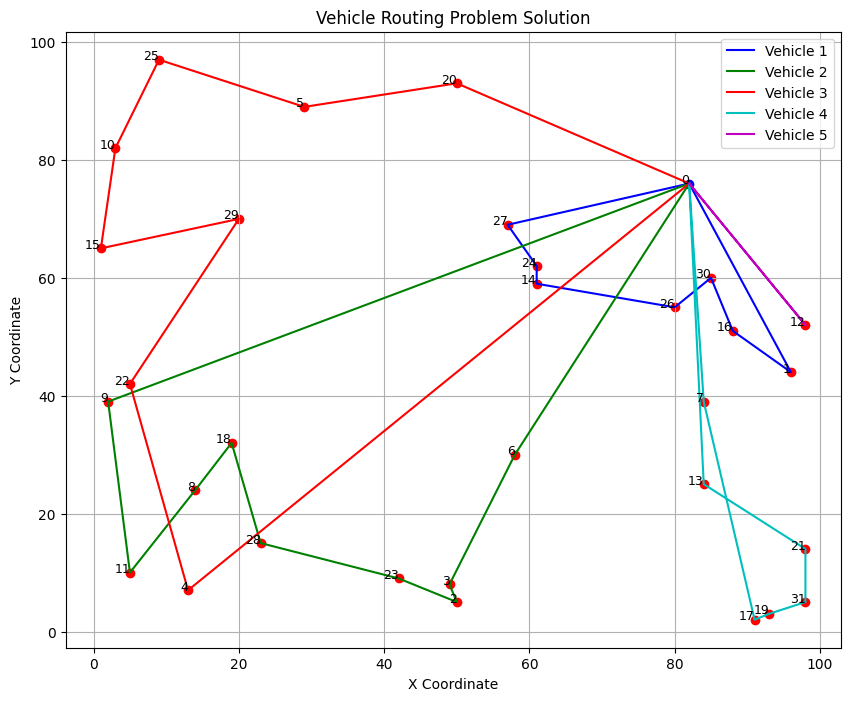

In [23]:
from dataclasses import dataclass

@dataclass
class ConstructionContext:
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray
    pheromone_matrix: np.ndarray
    heuristic_matrix: np.ndarray
    alpha: float
    beta: float
    


def construction_heuristic():
    num_ants = 50
    num_iterations = 100
    alpha = 1.0
    beta = 5.0
    rho = 0.5
    Q = 100
    return num_ants, num_iterations, alpha, beta, rho, Q
    
    
def ant_colony_optimization(data, num_ants=10, num_iterations=100, alpha=1, beta=2, rho=0.5, Q=100):
    num_locations = data['num_locations']
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    distance_matrix = np.array(data['distance_matrix'])
    demands = data['demand']
    capacity = data['vehicle_capacity']
    
    pheromone = np.ones((num_locations, num_locations))
    best_routes = None
    best_distance = float('inf')
    
    for _ in range(num_iterations):
        all_routes = []
        all_distances = []
        
        for _ in range(num_ants):
            routes = [[] for _ in range(num_vehicles)]
            vehicle_loads = [0] * num_vehicles
            unvisited = set(range(num_locations)) - {depot}
            
            for vehicle_id in range(num_vehicles):
                routes[vehicle_id].append(depot)
                current_node = depot
                
                while unvisited:
                    probabilities = []
                    nodes = []
                    
                    for node in unvisited:
                        if vehicle_loads[vehicle_id] + demands[node] <= capacity:
                            tau = pheromone[current_node][node] ** alpha
                            eta = (1 / (distance_matrix[current_node][node] + 1e-6)) ** beta
                            probabilities.append(tau * eta)
                            nodes.append(node)
                    
                    if not nodes:
                        break
                    
                    probabilities = np.array(probabilities) / sum(probabilities)
                    next_node = np.random.choice(nodes, p=probabilities)
                    routes[vehicle_id].append(next_node)
                    vehicle_loads[vehicle_id] += demands[next_node]
                    unvisited.remove(next_node)
                    current_node = next_node
                
                routes[vehicle_id].append(depot)
            
            total_distance = sum(
                sum(distance_matrix[routes[i][j]][routes[i][j+1]] for j in range(len(routes[i])-1))
                for i in range(num_vehicles)
            )
            
            all_routes.append(routes)
            all_distances.append(total_distance)
            
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = routes
        
        pheromone *= (1 - rho)
        for routes, total_distance in zip(all_routes, all_distances):
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone[route[i]][route[i + 1]] += Q / total_distance
    
    print(f"Best Distance: {best_distance}")
    for i, route in enumerate(best_routes):
        print(f"Route {i}: {route}")
    return best_routes

# 运行示例
def solve(data):
    num_ants,num_iterations,alpha,beta,rho,Q = construction_heuristic()
    routes = ant_colony_optimization(data,num_ants,num_iterations,alpha,beta,rho,Q)
    return routes
    
def evaluate(data):
    routes = solve(data)
    return routes


routes = evaluate(instance)
plot_CVRP_solution(routes, instance['locations'])

In [25]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple

class FunSearch:
    def run(self, func):
        return func

    def evolve(self, func):
        return func

funsearch = FunSearch()

@dataclass
class ConstructionContext:
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray
    pheromone_matrix: np.ndarray
    heuristic_matrix: np.ndarray
    alpha: float
    beta: float
    
# ========== 构建参数阶段 ==========
@funsearch.evolve
def construction_heuristic():
    """
    仅修改相关参数 
    必须return num_ants,num_iterations,alpha,beta,rho,Q
    """
    num_ants=10
    num_iterations=100
    alpha=1
    beta=2
    rho=0.5
    Q=100
    return 50, 100, 1.0, 2.0, 0.5, 100
    
    
def ant_colony_optimization(data, num_ants=10, num_iterations=100, alpha=1, beta=2, rho=0.5, Q=100):
    num_locations = data['num_locations']
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    distance_matrix = np.array(data['distance_matrix'])
    demands = data['demand']
    capacity = data['vehicle_capacity']
    
    pheromone = np.ones((num_locations, num_locations))
    best_routes = None
    best_distance = float('inf')
    
    for _ in range(num_iterations):
        all_routes = []
        all_distances = []
        
        for _ in range(num_ants):
            routes = [[] for _ in range(num_vehicles)]
            vehicle_loads = [0] * num_vehicles
            unvisited = set(range(num_locations)) - {depot}
            
            for vehicle_id in range(num_vehicles):
                routes[vehicle_id].append(depot)
                current_node = depot
                
                while unvisited:
                    probabilities = []
                    nodes = []
                    
                    for node in unvisited:
                        if vehicle_loads[vehicle_id] + demands[node] <= capacity:
                            tau = pheromone[current_node][node] ** alpha
                            eta = (1 / (distance_matrix[current_node][node] + 1e-6)) ** beta
                            probabilities.append(tau * eta)
                            nodes.append(node)
                    
                    if not nodes:
                        break
                    
                    probabilities = np.array(probabilities) / sum(probabilities)
                    next_node = np.random.choice(nodes, p=probabilities)
                    routes[vehicle_id].append(next_node)
                    vehicle_loads[vehicle_id] += demands[next_node]
                    unvisited.remove(next_node)
                    current_node = next_node
                
                routes[vehicle_id].append(depot)
            
            total_distance = sum(
                sum(distance_matrix[routes[i][j]][routes[i][j+1]] for j in range(len(routes[i])-1))
                for i in range(num_vehicles)
            )
            
            all_routes.append(routes)
            all_distances.append(total_distance)
            
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = routes
        
        pheromone *= (1 - rho)
        for routes, total_distance in zip(all_routes, all_distances):
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone[route[i]][route[i + 1]] += Q / total_distance
    
    print(f"Best Distance: {best_distance}")
    for i, route in enumerate(best_routes):
        print(f"Route {i}: {route}")
    return best_routes

# 运行示例
def solve(data):
    num_ants,num_iterations,alpha,beta,rho,Q = construction_heuristic()
    routes = ant_colony_optimization(data,num_ants,num_iterations,alpha,beta,rho,Q)
    return routes
    
@funsearch.run
def evaluate(data):
    routes = solve(data)
    return routes

routes = evaluate(instance)


Best Distance: 874.8145491143207
Route 0: [0, 27, 24, 14, 26, 16, 1, 30, 0]
Route 1: [0, 20, 5, 25, 10, 15, 9, 22, 8, 18, 29, 0]
Route 2: [0, 6, 3, 2, 23, 28, 4, 11, 0]
Route 3: [0, 12, 21, 31, 19, 17, 0]
Route 4: [0, 13, 7, 0]
